# Forecasting for variable: power_transport_vehicles

The objective of this notebook is to create a model that is able to forecast the values of the above mentioned variable. To do so, we will obatin the data for the entire period (2022-07-01 to 2023-09-19) and divide it between training data (2022-07-01 to 2023-06-30) and test data (2023-07-01 to 2023-09-19).

After dividing the datset, we will perform an analysis on the time series and apply the apporpiate ARIMA or SARIMA model that best works for forecasting.

Finally, we will create and save a model that is able to predict the values for the next day (one per hour of the next day).

In [1]:
import pandas as pd

In [2]:
cd ..

/Users/johanbarreiro/Documents/GitHub/vl_optimizer


## Get the data

In [3]:
input_path = 'data/synthesized_data/production_synthesized.csv'
df = pd.read_csv(input_path)

In [4]:
processed_df = pd.read_csv('data/processed_data/industrial_sites_processed/2024-07-05T01-00-40_industrial_site2_processed.csv')
time_data = processed_df[['Time','day_of_week_sin', 'is_weekend', 'hour_sin', 'hour_cos',
    'day_of_month_sin', 'day_of_week_cos', 'day_of_month_cos',
    'month_sin', 'month_cos']]

In [5]:
input_column = 'power_transport_vehicles'
entire_data = df[input_column]
entire_data =pd.Series(entire_data)

In [6]:
entire_data

0         9.841900
1        23.030950
2        19.882106
3        14.685432
4         3.907279
           ...    
10685    13.006434
10686    19.908993
10687     3.109464
10688    34.877178
10689    10.624538
Name: power_transport_vehicles, Length: 10690, dtype: float64

In [7]:
time_data['power_transport_vehicles_consumption'] = entire_data

/var/folders/9k/rnh189dj1_95w5p98sc88vbh0000gn/T/ipykernel_8721/2114199589.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_data['power_transport_vehicles_consumption'] = entire_data


In [8]:
time_data.head()

,Time,day_of_week_sin,is_weekend,hour_sin,hour_cos,day_of_month_sin,day_of_week_cos,day_of_month_cos,month_sin,month_cos,power_transport_vehicles_consumption
0,2022-07-01 00:00:00,-0.433884,0.0,0.000000,1.000000,0.201299,-0.900969,0.97953,-0.5,-0.866025,9.841900
1,2022-07-01 01:00:00,-0.433884,0.0,0.258819,0.965926,0.201299,-0.900969,0.97953,-0.5,-0.866025,23.030950
2,2022-07-01 02:00:00,-0.433884,0.0,0.500000,0.866025,0.201299,-0.900969,0.97953,-0.5,-0.866025,19.882106
3,2022-07-01 03:00:00,-0.433884,0.0,0.707107,0.707107,0.201299,-0.900969,0.97953,-0.5,-0.866025,14.685432
4,2022-07-01 04:00:00,-0.433884,0.0,0.866025,0.500000,0.201299,-0.900969,0.97953,-0.5,-0.866025,3.907279


## Target Data transformation for unstable values

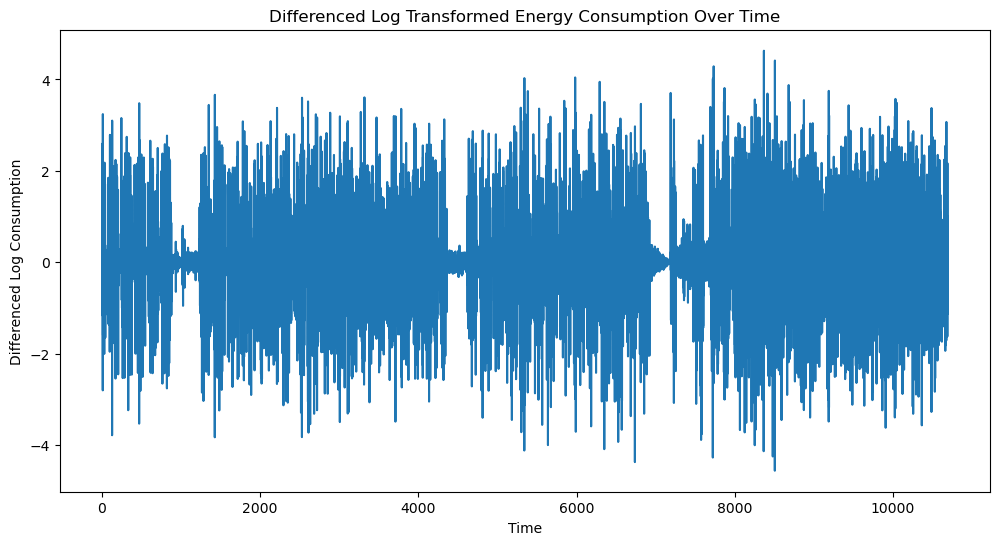

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with the energy consumption data
time_data = time_data.dropna()

# Log transformation
time_data['log_consumption'] = np.log(time_data['power_transport_vehicles_consumption'] + 1)

# Differencing
time_data['diff_consumption'] = time_data['log_consumption'].diff()



# Plot the transformed data
plt.figure(figsize=(12, 6))
plt.plot(time_data['diff_consumption'])
plt.title('Differenced Log Transformed Energy Consumption Over Time')
plt.xlabel('Time')
plt.ylabel('Differenced Log Consumption')
plt.show()

## Train-test split

In [10]:
from datetime import datetime

# Define the dates
train_start_date = datetime(2022, 7, 1)
train_end_date = datetime(2023, 7, 1) # as we include the 30th of July completely

# Calculate the difference
difference_days = train_end_date - train_start_date

# Calculate the difference in hours
difference_hours = difference_days.total_seconds() / 3600

# Print the differences
print("Difference in days:", difference_days.days)
print("Difference in hours:", difference_hours)

Difference in days: 365
Difference in hours: 8760.0


In [11]:
train_data = time_data[0:int(difference_hours)+1].dropna()
test_data = time_data[int(difference_hours)+1:].reset_index()

In [12]:
# Define the features and the target variable
features = [
    'day_of_week_sin', 'is_weekend', 'hour_cos',
    'day_of_month_sin',
    'month_cos'
]
target = 'diff_consumption'

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')




Train MAE: 0.5286843169010744
Test MAE: 0.9138225672130789


In [14]:
from sklearn.metrics import r2_score

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f'Train R^2 Score: {train_r2}')
print(f'Test R^2 Score: {test_r2}')

Train R^2 Score: 0.4988172899792901
Test R^2 Score: -0.11052204982739089


## Save the Model

In [15]:
import joblib
import os

# Define the directory and file name
directory = 'forecasting/forecasters'
file_name = input_column
file_path = directory + '/' + file_name + '.joblib'

# Ensure the directory exists
os.makedirs(directory, exist_ok=True)

# Save the model to the specified directory
joblib.dump(model, file_path)

print(f"Model saved successfully at {file_path}")

Model saved successfully at forecasting/forecasters/power_transport_vehicles.joblib


## Forecast Future Values

In [16]:
# Load the saved model
import joblib

directory = 'forecasting/forecasters'
file_name = input_column
file_path = directory + '/' + file_name + '.joblib'
model = joblib.load(file_path)

# Make predictions on the test set
X_test = test_data[features]
y_pred_test = model.predict(X_test)

test_data['y_pred_test'] = y_pred_test

test_data.to_csv('data/forecasted_data/test.csv', index=False)

In [17]:
list(train_data['log_consumption'])[-1]

3.411721155364884

In [18]:
# Load the saved model
import joblib

directory = 'forecasting/forecasters'
file_name = input_column
file_path = directory + '/' + file_name + '.joblib'
model = joblib.load(file_path)

output_column_name = 'forecasted_' + input_column

# Make predictions on the test set
X_test = test_data[features]
y_pred_test = model.predict(X_test)


output_column = []

for index, row in test_data.iterrows():

    if index == 0:
        avg_yesterday_value = sum(list(train_data['log_consumption'])[-24:])/24
        log_diff_pred = row['y_pred_test']
        undone_value = np.exp(avg_yesterday_value + log_diff_pred) - 1
    else:
        last_value = np.log(output_column[-1] + 1)
        log_diff_pred = row['y_pred_test']
        
        undone_value = np.exp(last_value + log_diff_pred) - 1

    output_column.append(undone_value)

# predictions = []
# for index, row in test_data.iterrows():
#     if index == 0:
#         last_log_consumption = train_data['log_consumption'].iloc[-1]
#         undone_value = np.exp(last_log_consumption + row['y_pred_test']) - 1
#     else:
#         previous_log_consumption = np.log(predictions[-1] + 1)
#         undone_value = np.exp(previous_log_consumption + row['y_pred_test']) - 1
#   
#     predictions.append(undone_value)  

# # Undo the differencing
# # Note: y_pred_test[0] should be added to the last value of log_consumption in the train set
# last_log_consumption = train_data['log_consumption'].iloc[-1]
# log_consumption_pred = np.r_[last_log_consumption, y_pred_test].cumsum()
# 
# # Undo the log transformation
# predicted_consumption = np.exp(log_consumption_pred) - 1
# 
# Create a DataFrame with 'Time' and predicted values
prediction_df = pd.DataFrame({
    'Time': test_data['Time'],
    output_column_name: output_column 
})

# Save the predictions to a CSV file
prediction_df.to_csv(f'data/forecasted_data/{input_column}.csv', index=False)

print(f"Predicted values saved successfully to '{input_column}.csv'")

Predicted values saved successfully to 'power_transport_vehicles.csv'


In [19]:



# Evaluate the model
output_mae = mean_absolute_error(test_data[input_column+'_consumption'], prediction_df[output_column_name])
print(f'Output MAE: {output_mae}')

r2 = r2_score(test_data[input_column+'_consumption'], prediction_df[output_column_name])
print(f'R^2 Score: {r2}')



Output MAE: 49639.10147266843
R^2 Score: -219437058.89824155
